In [1]:
#this produces boxplots comparing how ML classification errors are within and between phyla (class and order).

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.stats import norm
from scipy import stats
import random
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# FUNCTIONS

def get_most_abundant_labels(labels_lists, top_n=15):
    # Combine both lists
    combined_list = []
    for list in labels_lists:
        combined_list += list
    
    # Count the occurrences of each label
    label_counts = Counter(combined_list)
    
    # Get the top N most common labels
    most_common_labels = label_counts.most_common(top_n)

    # Return only the labels, not the counts
    return [label for label, count in most_common_labels]

def plot_rel_bars(labels_lists):
    categories = get_most_abundant_labels(labels_lists, top_n=15)
    
    # Number of bars (one for each list)
    num_bars = len(labels_lists)
    
    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Loop through each list and plot a stacked bar
    for i, labels in enumerate(labels_lists):
        # Count occurrences of each label in the current list
        counts = [labels.count(category) for category in categories]
        # Calculate relative abundance for each category in the current list
        total = len(labels)
        relative_abundance = np.array(counts) / total
        # Create the stacked bar for this list
        bottom = 0  # Initialize the bottom for stacking
        for j, (category, count) in enumerate(zip(categories, relative_abundance)):
            ax.bar(i, count, color=unique_taxa_colors[category], bottom=bottom, label=category if i == 0 else "")  # Avoid duplicate labels
            bottom += count  # Update the bottom for the next category in the stack
    
    # Set axis labels, title, and legend
    ax.set_ylabel('Relative Abundance')
    ax.set_title('Relative Abundance of Labels in Multiple Lists')
    ax.set_xticks(range(num_bars))  # Position the ticks for each bar
    ax.set_xticklabels([f'Sample {i+1}' for i in range(num_bars)])  # Label each bar as List 1, List 2, etc.
    ax.legend(loc='upper left', fontsize=14, title="Species", bbox_to_anchor=(1, .9))
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    plt.close()

def mean_difference_in_relative_abundance(list1, list2):
    # Combine the lists to get all unique labels
    all_labels = set(list1 + list2)

    # Count occurrences of labels in both lists
    count_list1 = Counter(list1)
    count_list2 = Counter(list2)
    
    # Calculate relative abundance for both lists
    total_list1 = len(list1)
    total_list2 = len(list2)
    
    # Calculate the relative abundance for each label
    relative_abundance1 = {label: count_list1[label] / total_list1 for label in all_labels}
    relative_abundance2 = {label: count_list2[label] / total_list2 for label in all_labels}
    
    # Calculate the absolute differences in relative abundance
    differences = [abs(relative_abundance1.get(label, 0) - relative_abundance2.get(label, 0)) for label in all_labels]
    
    # Return the mean of the differences
    return sum(differences) / len(differences)

def bray_difference_in_relative_abundance(list1, list2):
    # Combine the lists to get all unique labels
    all_labels = set(list1 + list2)

    # Count occurrences of labels in both lists
    count_list1 = Counter(list1)
    count_list2 = Counter(list2)
    
    # Calculate relative abundance for both lists
    total_list1 = len(list1)
    total_list2 = len(list2)
    
    # Calculate the relative abundance for each label
    relative_abundance1 = {label: count_list1[label] / total_list1 for label in all_labels}
    relative_abundance2 = {label: count_list2[label] / total_list2 for label in all_labels}
    
    # Calculate the absolute differences in relative abundance
    diffs = [abs(relative_abundance1.get(label, 0) - relative_abundance2.get(label, 0)) for label in all_labels]
    sums = [relative_abundance1.get(label, 0) + relative_abundance2.get(label, 0) for label in all_labels]
    # Return the mean of the differences
    return sum(diffs)/sum(sums)

def show_sampling_proportion(pop_size, sample_size, proportion):
    
    # Create the array with 75% 1s and 25% 0s
    array = np.concatenate([np.ones(int(pop_size * proportion)), np.zeros(int(pop_size * (1 - proportion)))])
    
    # Shuffle the array to ensure randomness
    np.random.shuffle(array)
    
    counts = []
    # Take n random samples from the array
    for i in range(1, sample_size):
        random_samples = np.random.choice(array, size=i, replace=False)
        count = np.mean(random_samples)
        counts.append(count)
    # print("Random samples:", random_samples)
    # print("counts:", counts)
    # plt.ylim([.45, .75])
    plt.plot(counts)
    plt.show()
    plt.close()

def get_conf_interval(sample_size, hits):
    # Sample proportion
    p_hat = hits / sample_size
    
    # Standard error of the proportion
    se = np.sqrt(p_hat * (1 - p_hat) / sample_size)
    
    # Z-score for 95% confidence level
    z = stats.norm.ppf(0.995)  # 99% confidence -> 0.995 is the upper tail of the normal distribution
    
    # Margin of error
    margin_of_error = z * se
    
    # Confidence interval
    ci_lower = p_hat - margin_of_error
    ci_upper = p_hat + margin_of_error
    
    print(f"Sample proportion: {p_hat:.4f}")
    print(f"99% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

def get_sample_dissimilarities(df):
    sampleNames = df['sample_id'].unique()
    realArray = []
    predArray = []
    meanDissArray = []
    for sampleName in sampleNames:
        sampledf = df[df['sample_id'] == sampleName]
        realNames = sampledf['object_newname'].to_numpy()
        predNames = sampledf['predicted_newName'].to_numpy()
        realArray.append(realNames)
        predArray.append(predNames)
        mean_diss = mean_difference_in_relative_abundance(list(realNames), list(predNames))
        meanDissArray.append(mean_diss)
    return meanDissArray

def get_matches(df):  
    correct = 0
    for i, row in df.iterrows():
        if row['object_newname'] == row['predicted_newName']:
            correct += 1
    return correct, len(df), correct/len(df)

In [3]:
#Go to import_ml_df.ipynb and run it to get ml_df_5000, or uncomment the next line and run it here.

#%run 'import_ml_df.ipynb'

%store -r ml_df_5000

#if you need the predictions using unlimited class sizes (max), load here.
%store -r ml_df_max

In [4]:
gulf_max_df = ml_df_max[ml_df_max['regionYear'] == 'Gulf'].copy()
gulf_max_df['regionYear'] = 'Gulf Unlim.'
ml_df = pd.concat([ml_df_5000, gulf_max_df])

In [5]:
# replace name changes
ml_df = ml_df.replace({
                        'Gulf': '2 Gulf',
                        'Gulf Unlim.': '1 Gulf Unlim.',
                        'Pacific': '3 Pacific',
                        'NL 2020': '4 NL 2020',
                        'NL 2021': '5 NL 2021',
                      })

In [6]:
#TAXA GROUPINGS

# Copepoda is CLASS level
    #Calanoida is an order
        #Temora
        #Eurytemora
        #Acartia
        #Calanus
        #Centropages
        #Labidocera
        #Paracalanus
        #Pseudocalanus
        #Microcalanus
        #Pseudodiaptomus
        #Tortanus
        #Corycaeidae
    #Podoplea is a super order
        #Oithona is a genus
        #Harpacticoida is an order
# Malacostraca is a class:
    # Decopoda is an ORDER
        #Decapoda- non-brachyura
        #Decapoda- branchyura
    # Euphausiacea is an order
# Cirripedia is a subclass
# Podonidae is a family, but no other inside its class
    #Podon/Pleopsis
    #Evadne
# Chordata is a phylum
    # Tunicata is a subphylum of phylum chordata
        # Copelata is an order
            # Fritillaria is a genus
            # Oikopleura
        # Ascidiacea is a class
    # Osteichthyes is a superclass
# Mollusca is a phylum
    # Gastropoda is a class
    # Bivalvia is a class
# Hydrozoa is a class
    # Calycophorae is a suborder
    # Obelia is a genus
# Bryozoa is a phylum
# Echinodermata is a phylum
# Polychaeta is a class
# Platyhelminthes/Nemertea are both phyla
# Chaetognatha is a phylum


taxa_by_order = {
    "Calanoida": [
        'Calanoida',
        'Temora',
        'Eurytemora',
        'Acartia',
        'Calanus',
        'Centropages',
        'Labidocera',
        'Paracalanus',
        'Pseudocalanus',
        'Microcalanus',
        'Pseudodiaptomus',
        'Tortanus',
        'Corycaeidae',
        'Copepoda',
    ],
    "Oithona": [
        "Oithona",
        'Copepoda',
    ],
    "Harpacticoida": [
        "Harpacticoida",
        'Copepoda',
    ],
    "Decapoda": [
        "Decapoda"
    ],
    "Euphausiacea": [
        'Euphausiacea',
    ],
    "Cirripedia": [
        "Cirripedia"
    ],
    "Podonidae": [
        "Podon",
        "Evadne",
    ],
    "Copelata": [
        "Fritillaria",
        "Oikopleura"
    ],
    "Ascidiacea": [
        "Ascidiacea"
    ],
    "Osteichthyes": [
        "Osteichthyes"
    ],
    "Gastropoda": [
        "Gastropoda"
    ],
    "Bivalvia": [
        "Bivalvia"
    ],
    "Calycophorae": [
        "Calycophorae",
        'Hydrozoa',
    ],
    "Obelia": [
        "Obelia",
        'Hydrozoa',
    ],
    "Bryozoa": [
        "Bryozoa"
    ],
    "Echinodermata": [
        "Echinodermata"
    ],
    "Polychaeta": [
        "Polychaeta"
    ],
    "Platyhelminthes": [
        "Platyhelminthes"
    ],
    "Chaetognatha": [
        "Chaetognatha",
    ],
}


taxa_by_class = {
    "Copepoda": [
        'Calanoida',
        'Temora',
        'Eurytemora',
        'Acartia',
        'Calanus',
        'Centropages',
        'Labidocera',
        'Paracalanus',
        'Pseudocalanus',
        'Microcalanus',
        'Pseudodiaptomus',
        'Tortanus',
        'Corycaeidae',
        'Oithona',
        'Harpacticoida',
        'Copepoda',
    ],
    "Malacostraca": [
        "Decapoda",
        "Euphausiacea",
    ],
    "Cirripedia": [
        "Cirripedia"
    ],
    "Podonidae": [
        "Podon",
        "Evadne",
    ],
    "Copelata": [
        "Fritillaria",
        "Oikopleura"
    ],
    "Ascidiacea": [
        "Ascidiacea"
    ],
    "Osteichthyes": [
        "Osteichthyes"
    ],
    "Gastropoda": [
        "Gastropoda"
    ],
    "Bivalvia": [
        "Bivalvia"
    ],
    "Hydrozoa": [
        "Calycophorae",
        "Obelia",
        'Hydrozoa',
    ],
    "Bryozoa": [
        "Bryozoa"
    ],
    "Echinodermata": [
        "Echinodermata"
    ],
    "Polychaeta": [
        "Polychaeta"
    ],
    "Platyhelminthes": [
        "Platyhelminthes"
    ],
    "Chaetognatha": [
        "Chaetognatha",
    ],
}

In [7]:
def check_if_same_group(taxa1, taxa2, tree_dict):
    taxa1_found = False
    taxa2_found = False
    for groupName, group in tree_dict.items():
        for checkName in group:
            
            if checkName in taxa1:
                taxa1_group = groupName
                taxa1_found = True
                break
        if taxa1_found:
            break
    else:
        print(f"could not find group for: {taxa1}")
        return
    for groupName, group in tree_dict.items():
        for checkName in group:
            if checkName in taxa2:
                taxa2_group = groupName
                taxa2_found = True
                break
        if taxa2_found:
            break
    else:
        print(f"could not find group for: {taxa2}")
        return
    for taxa in tree_dict[taxa1_group]:
        if taxa in taxa2:
            return True
    for taxa in tree_dict[taxa2_group]:
        if taxa in taxa1:
            return True
    # print(f"{taxa1} not in same group as {taxa2}")
    return False


def get_group(taxa1, tree_dict):
    for groupName, group in tree_dict.items():
        for checkName in group:
            if checkName in taxa1:
                return groupName
    return "No Group Found"

check_if_same_group('Oithona', 'Copepoda', taxa_by_order)

True

In [8]:
ml_df['regionYear'].unique()

array(['2 Gulf', '3 Pacific', '4 NL 2020', '5 NL 2021', '1 Gulf Unlim.'],
      dtype=object)

-------------- 1 Gulf Unlim. ----------------
AMMP_Gulf_StPeters_1_20200903HT_250UM
AMMP_Gulf_StPeters_1_20200903LT_250UM
AMMP_Gulf_StPeters_1_20200904HT_250UM
AMMP_Gulf_StPeters_2B_20200903_250UM
AMMP_Gulf_StPeters_2_20200903HT_250UM
AMMP_Gulf_StPeters_2_20200904HT_250UM
AMMP_Gulf_StPeters_3B_20200903_250UM
AMMP_Gulf_StPeters_3_20200903HT_250UM
AMMP_Gulf_StPeters_3_20200903LT_250UM
AMMP_Gulf_StPeters_3_20200904HT_250UM


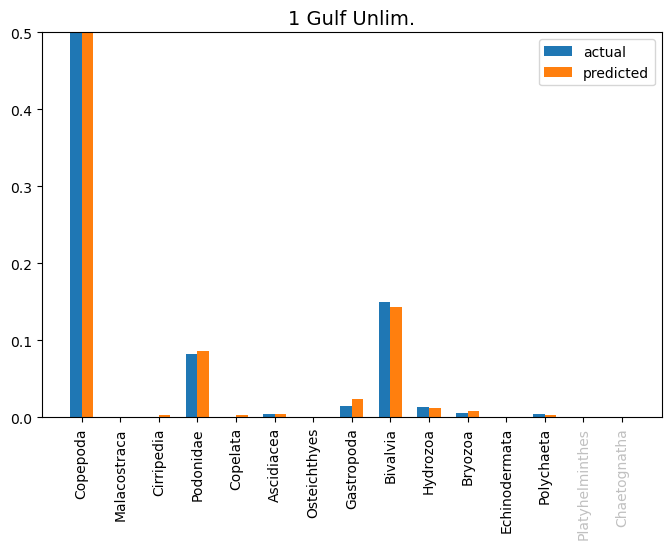

-------------- 2 Gulf ----------------
AMMP_Gulf_StPeters_1_20200903HT_250UM
AMMP_Gulf_StPeters_1_20200903LT_250UM
AMMP_Gulf_StPeters_1_20200904HT_250UM
AMMP_Gulf_StPeters_2B_20200903_250UM
AMMP_Gulf_StPeters_2_20200903HT_250UM
AMMP_Gulf_StPeters_2_20200904HT_250UM
AMMP_Gulf_StPeters_3B_20200903_250UM
AMMP_Gulf_StPeters_3_20200903HT_250UM
AMMP_Gulf_StPeters_3_20200903LT_250UM
AMMP_Gulf_StPeters_3_20200904HT_250UM


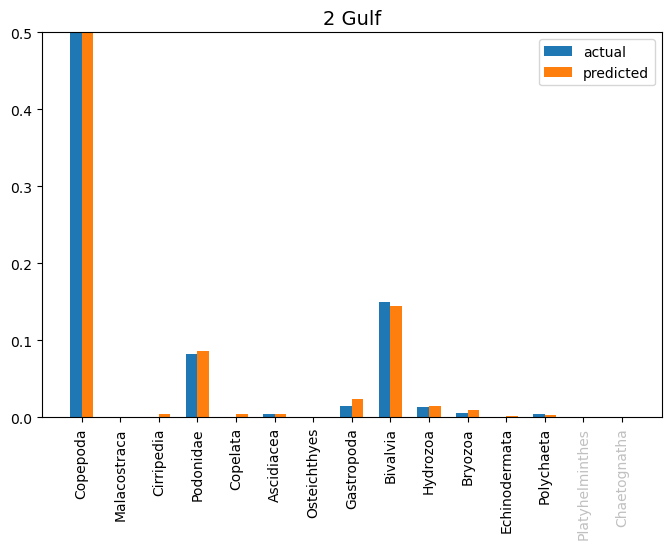

-------------- 3 Pacific ----------------
AMMP_PA_S04W01_20210609HT_250um
AMMP_PA_S04W01_20210609LT_250um
AMMP_PA_S04W01_20210610HT_250um
AMMP_PA_S04W01_20210610LT_250um
AMMP_PA_S04W15_20210609HT_250um
AMMP_PA_S04W15_20210609LT_250um
AMMP_PA_S04W15_20210610LT_250um
AMMP_PA_S04W20_20210609HT_250um
AMMP_PA_S04W20_20210609LT_250um
AMMP_PA_S04W20_20210610LT_250um


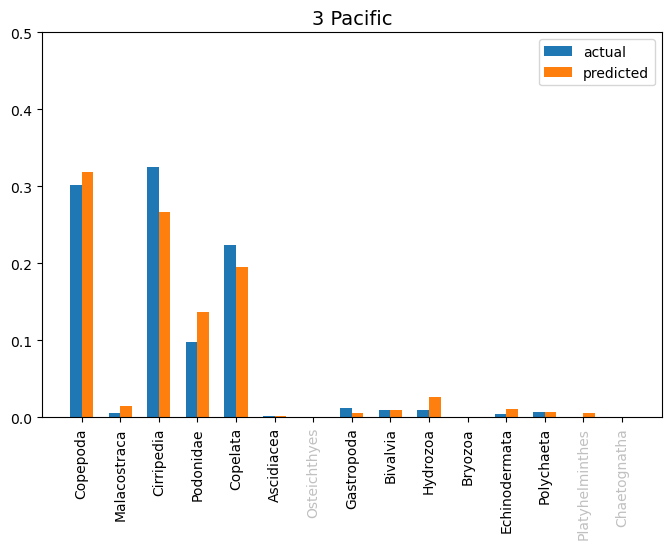

-------------- 4 NL 2020 ----------------
AMMP_NL_S01_33_20200916AM_250UM
AMMP_NL_S01_33_20200916PM_250UM
AMMP_NL_S01_41_20200916AM_250UM
AMMP_NL_S01_41_20200916PM_250UM
AMMP_NL_S01_51_20200915PM_250UM
AMMP_NL_S01_51_20200916AM_250UM
AMMP_NL_S01_51_20200916PM_250UM
AMMP_NL_S01_77_20200915PM_250UM
AMMP_NL_S01_77_20200916AM_250UM
AMMP_NL_S01_77_20200916PM_250UM


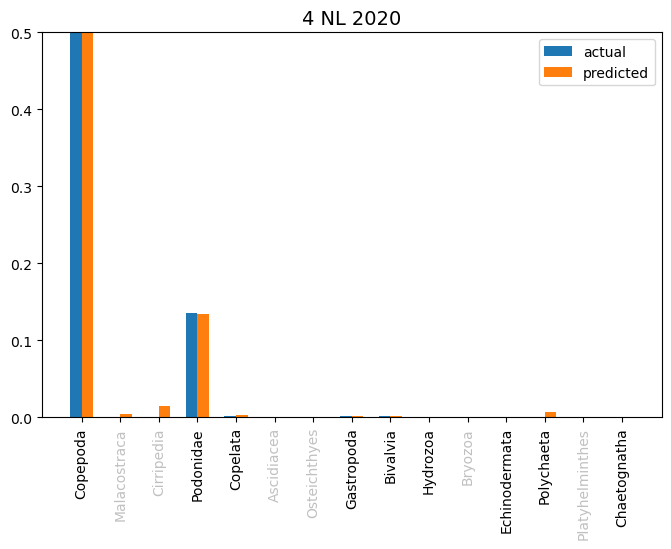

-------------- 5 NL 2021 ----------------
21_10_05_NL_S1_Z17_0752_250
21_10_05_NL_S1_Z17_1406_250
21_10_05_NL_S1_Z41_0854_250
21_10_05_NL_S1_Z41_1327_250
21_10_06_NL_S1_Z17_0802_250
21_10_06_NL_S1_Z17_1442_250
21_10_06_NL_S1_Z41_0839_250
21_10_06_NL_S1_Z41_1412_250
21_10_07_NL_S1_Z17_0830_250
21_10_07_NL_S1_Z17_1459_250


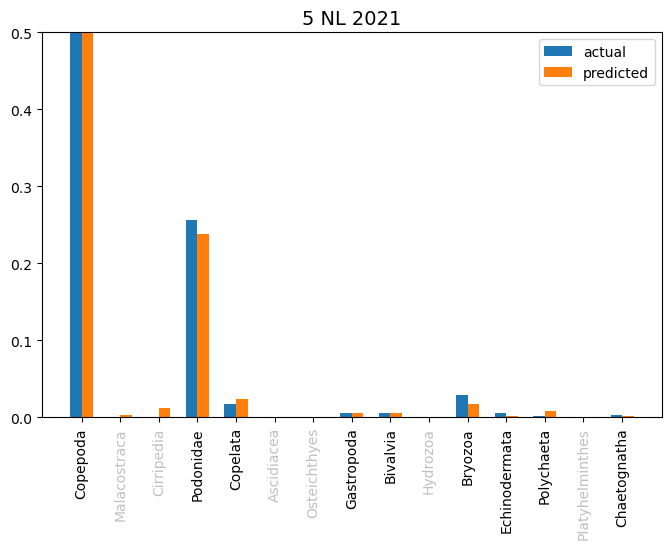

{'1 Gulf Unlim.': {'AMMP_Gulf_StPeters_1_20200903HT_250UM': 0.08344164283857551, 'AMMP_Gulf_StPeters_1_20200903LT_250UM': 0.09761321909424725, 'AMMP_Gulf_StPeters_1_20200904HT_250UM': 0.04976651100733823, 'AMMP_Gulf_StPeters_2B_20200903_250UM': 0.11986183074265976, 'AMMP_Gulf_StPeters_2_20200903HT_250UM': 0.29922027290448344, 'AMMP_Gulf_StPeters_2_20200904HT_250UM': 0.23006942781900885, 'AMMP_Gulf_StPeters_3B_20200903_250UM': 0.1736905478627333, 'AMMP_Gulf_StPeters_3_20200903HT_250UM': 0.2355307954193748, 'AMMP_Gulf_StPeters_3_20200903LT_250UM': 0.07011686143572621, 'AMMP_Gulf_StPeters_3_20200904HT_250UM': 0.20441988950276244}, '2 Gulf': {'AMMP_Gulf_StPeters_1_20200903HT_250UM': 0.10345723940733038, 'AMMP_Gulf_StPeters_1_20200903LT_250UM': 0.28671970624235005, 'AMMP_Gulf_StPeters_1_20200904HT_250UM': 0.05416944629753169, 'AMMP_Gulf_StPeters_2B_20200903_250UM': 0.37512953367875645, 'AMMP_Gulf_StPeters_2_20200903HT_250UM': 0.4800194931773879, 'AMMP_Gulf_StPeters_2_20200904HT_250UM': 0.42

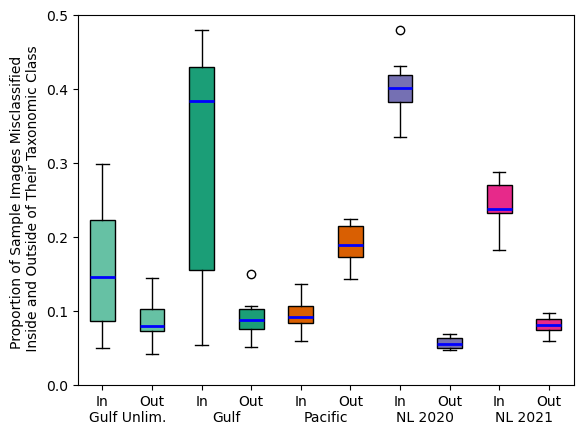

In [9]:
#calculate errors within order and without

def show_grouping_stats(ml_df, group_level):
    ingroup_error_dict = {}
    outgroup_error_dict = {}
    if group_level == 'order':
        taxa_tree = taxa_by_order
    elif group_level == 'class':
        taxa_tree = taxa_by_class
    else:
        print('invalid group level')
        return
    regionYears = ml_df['regionYear'].unique()
    regionYears.sort()
    # fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for r, regionYear in enumerate(regionYears):
        print('--------------', regionYear, '----------------')
        region_df = ml_df[ml_df['regionYear'] == regionYear]
        samples = region_df['sample_id'].unique()
        samples.sort()
        ingroup_error_dict[regionYear] = {}
        outgroup_error_dict[regionYear] = {}
        sample_percs = []
        sample_pred_percs = []
        for sample in samples:
            sample_df = region_df[region_df['sample_id'] == sample]
            # ax = axes[r]
            group_counts = {}
            pred_group_counts = {}
            for key in taxa_tree.keys():
                group_counts[key] = 0
                pred_group_counts[key] = 0
            ingroup_errors = 0
            outgroup_errors = 0
            hits = 0
    
            for i, row in sample_df.iterrows():
                # if 'Oithona' in row['object_newname']:
                #     print('Oithona')
                group = get_group(row['object_newname'], taxa_tree)
                group_counts[group] += 1
                pred_group = get_group(row['predicted_newName'], taxa_tree)
                pred_group_counts[pred_group] += 1
                if row['object_newname'] != row['predicted_newName']:
                    if check_if_same_group(row['object_newname'], row['predicted_newName'], taxa_tree):
                        ingroup_errors += 1
                    else:
                        outgroup_errors += 1
                else:
                    hits += 1

            total_counts = np.sum(list(group_counts.values()))
            pred_total_counts = np.sum(list(pred_group_counts.values()))
            ingroup_error_dict[regionYear][sample] = ingroup_errors / (ingroup_errors + outgroup_errors + hits)
            outgroup_error_dict[regionYear][sample] = outgroup_errors/(ingroup_errors + outgroup_errors + hits)
            percs = list(np.array(list(group_counts.values()))/total_counts)
            pred_percs = list(np.array(list(pred_group_counts.values()))/pred_total_counts)
            print(sample)
            width = 0.3
            xbars = np.array(range(len(group_counts.keys())))

            sample_percs.append(percs)
            sample_pred_percs.append(pred_percs)
            # print(sample_percs)
        sample_percs = np.array(sample_percs)
        sample_mean_percs = np.mean(sample_percs, axis=0)
        sample_pred_percs = np.array(sample_pred_percs)
        sample_mean_pred_percs = np.mean(sample_pred_percs, axis=0)
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.bar(xbars-.15, sample_mean_percs, width=width, label='actual')
        ax.bar(xbars+.15, sample_mean_pred_percs, width=width, label='predicted')
        colors = ['black' if x > 0 else 'silver' for x in sample_mean_percs]
        ax.set_xticks(range(len(group_counts.keys())), group_counts.keys(), rotation=90)
        tick_labels = ax.get_xticklabels()
        for i, label in enumerate(tick_labels):
            label.set_color(colors[i])
        ax.set_title(regionYear, fontsize=14)
        ax.set_ylim([0, 0.5])
        plt.legend()
        # fig.text(0.5, -.25, f"taxa level '{group_level}' or higher", ha='center', va='center')
        plt.show()
        plt.close()

    error_data = []
    print(ingroup_error_dict)
    for regionYear, region_data in ingroup_error_dict.items():
        data = []
        for sample_data in region_data.values():
            data.append(sample_data)
        # error_mean = np.mean(data)
        error_data.append(data)
        data = []
        for sample_data in outgroup_error_dict[regionYear].values():
            data.append(sample_data)
        error_data.append(data)
    error_data = np.array(error_data)
    # group error percentage bar graph
    bplot = plt.boxplot(error_data.T, patch_artist=True, medianprops=dict(color='blue', linewidth=2))
    colors = ['#66c1a4', '#1b9e77', '#d95f02', '#7570b3', '#e7298a']
    doubleColors = []
    for color in colors:
        doubleColors.append(color)
        doubleColors.append(color)
    regionColors = {'Pacific': '#d95f02', 'Gulf':'#1b9e77', 'NL 2020': '#7570b3', 'NL 2021': '#e7298a'}
    for patch, color in zip(bplot['boxes'], doubleColors):
        patch.set_facecolor(color)
    plt.xticks(range(1, len(regionYears) * 2 + 1), ['In' if x % 2 == 0 else 'Out' for x in list(range(len(regionYears)*2))])
    for r, regionYear in enumerate(regionYears):
        plt.text(r * 2 + 1.5, -.05, regionYear[2:], horizontalalignment='center')
    plt.ylim([0, 0.5])
    plt.ylabel(f"Proportion of Sample Images Misclassified \n Inside and Outside of Their Taxonomic {group_level.capitalize()}")
    # plt.title(f'Prop. of Misclassifications within Tax. {group_level.capitalize()}')
    plt.savefig(f"within_and_without_{group_level}.png")
    plt.show()
    plt.close()
    return ingroup_error_dict
in_order_error_dict = show_grouping_stats(ml_df, 'class')

-------------- 1 Gulf Unlim. ----------------
AMMP_Gulf_StPeters_1_20200903HT_250UM
AMMP_Gulf_StPeters_1_20200903LT_250UM
AMMP_Gulf_StPeters_1_20200904HT_250UM
AMMP_Gulf_StPeters_2B_20200903_250UM
AMMP_Gulf_StPeters_2_20200903HT_250UM
AMMP_Gulf_StPeters_2_20200904HT_250UM
AMMP_Gulf_StPeters_3B_20200903_250UM
AMMP_Gulf_StPeters_3_20200903HT_250UM
AMMP_Gulf_StPeters_3_20200903LT_250UM
AMMP_Gulf_StPeters_3_20200904HT_250UM


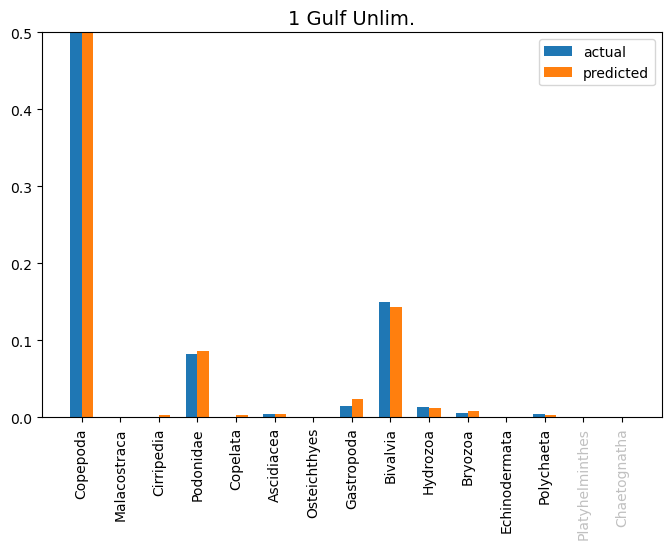

-------------- 2 Gulf ----------------
AMMP_Gulf_StPeters_1_20200903HT_250UM
AMMP_Gulf_StPeters_1_20200903LT_250UM
AMMP_Gulf_StPeters_1_20200904HT_250UM
AMMP_Gulf_StPeters_2B_20200903_250UM
AMMP_Gulf_StPeters_2_20200903HT_250UM
AMMP_Gulf_StPeters_2_20200904HT_250UM
AMMP_Gulf_StPeters_3B_20200903_250UM
AMMP_Gulf_StPeters_3_20200903HT_250UM
AMMP_Gulf_StPeters_3_20200903LT_250UM
AMMP_Gulf_StPeters_3_20200904HT_250UM


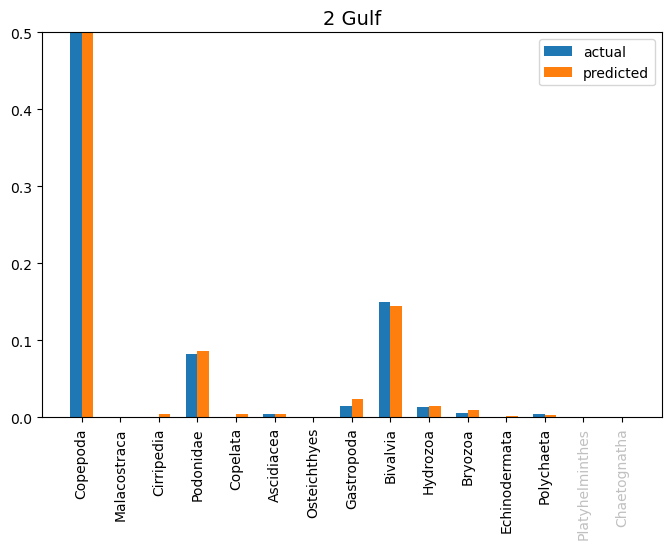

-------------- 3 Pacific ----------------
AMMP_PA_S04W01_20210609HT_250um
AMMP_PA_S04W01_20210609LT_250um
AMMP_PA_S04W01_20210610HT_250um
AMMP_PA_S04W01_20210610LT_250um
AMMP_PA_S04W15_20210609HT_250um
AMMP_PA_S04W15_20210609LT_250um
AMMP_PA_S04W15_20210610LT_250um
AMMP_PA_S04W20_20210609HT_250um
AMMP_PA_S04W20_20210609LT_250um
AMMP_PA_S04W20_20210610LT_250um


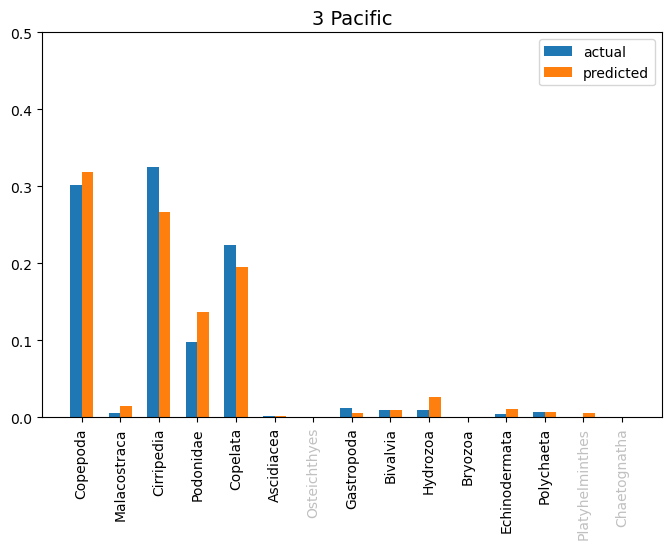

-------------- 4 NL 2020 ----------------
AMMP_NL_S01_33_20200916AM_250UM
AMMP_NL_S01_33_20200916PM_250UM
AMMP_NL_S01_41_20200916AM_250UM
AMMP_NL_S01_41_20200916PM_250UM
AMMP_NL_S01_51_20200915PM_250UM
AMMP_NL_S01_51_20200916AM_250UM
AMMP_NL_S01_51_20200916PM_250UM
AMMP_NL_S01_77_20200915PM_250UM
AMMP_NL_S01_77_20200916AM_250UM
AMMP_NL_S01_77_20200916PM_250UM


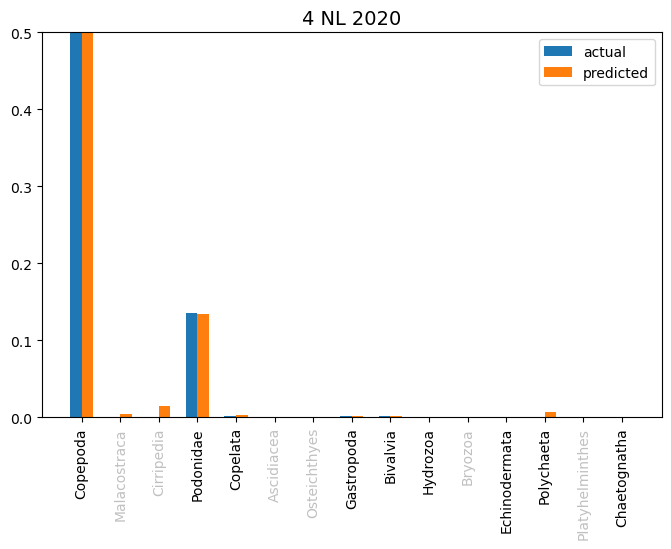

-------------- 5 NL 2021 ----------------
21_10_05_NL_S1_Z17_0752_250
21_10_05_NL_S1_Z17_1406_250
21_10_05_NL_S1_Z41_0854_250
21_10_05_NL_S1_Z41_1327_250
21_10_06_NL_S1_Z17_0802_250
21_10_06_NL_S1_Z17_1442_250
21_10_06_NL_S1_Z41_0839_250
21_10_06_NL_S1_Z41_1412_250
21_10_07_NL_S1_Z17_0830_250
21_10_07_NL_S1_Z17_1459_250


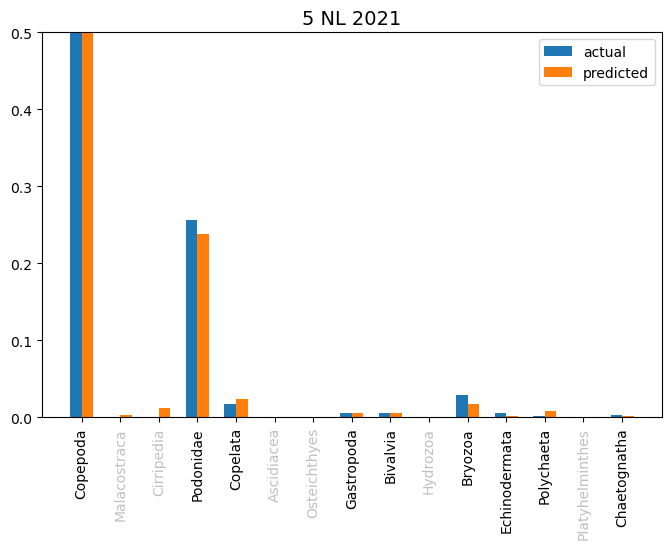

{'1 Gulf Unlim.': {'AMMP_Gulf_StPeters_1_20200903HT_250UM': 0.08344164283857551, 'AMMP_Gulf_StPeters_1_20200903LT_250UM': 0.09761321909424725, 'AMMP_Gulf_StPeters_1_20200904HT_250UM': 0.04976651100733823, 'AMMP_Gulf_StPeters_2B_20200903_250UM': 0.11986183074265976, 'AMMP_Gulf_StPeters_2_20200903HT_250UM': 0.29922027290448344, 'AMMP_Gulf_StPeters_2_20200904HT_250UM': 0.23006942781900885, 'AMMP_Gulf_StPeters_3B_20200903_250UM': 0.1736905478627333, 'AMMP_Gulf_StPeters_3_20200903HT_250UM': 0.2355307954193748, 'AMMP_Gulf_StPeters_3_20200903LT_250UM': 0.07011686143572621, 'AMMP_Gulf_StPeters_3_20200904HT_250UM': 0.20441988950276244}, '2 Gulf': {'AMMP_Gulf_StPeters_1_20200903HT_250UM': 0.10345723940733038, 'AMMP_Gulf_StPeters_1_20200903LT_250UM': 0.28671970624235005, 'AMMP_Gulf_StPeters_1_20200904HT_250UM': 0.05416944629753169, 'AMMP_Gulf_StPeters_2B_20200903_250UM': 0.37512953367875645, 'AMMP_Gulf_StPeters_2_20200903HT_250UM': 0.4800194931773879, 'AMMP_Gulf_StPeters_2_20200904HT_250UM': 0.42

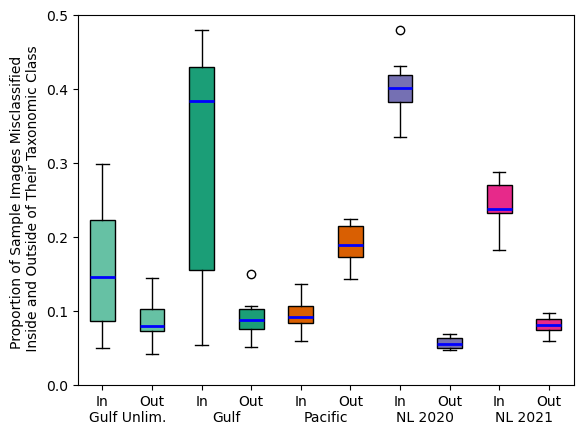

In [10]:
in_class_error_dict = show_grouping_stats(ml_df, 'class')